In [1]:
import ztfcosmo
import numpy as np
from astropy.cosmology import Planck18

# Access ZTF SN Ia DR2 data

In [2]:
data = ztfcosmo.get_data(good_coverage=True, good_lcfit=True)
data = data[ data["sn_type"].isin(["snia","snia-cosmo"]) &\
            data["redshift"].between(0.015, 0.06) &\
            (data["localrestframe_gz_err"]<3)]
data = data[~data["localrestframe_gz"].isna()]

In [3]:
# x0 to non-standardized Hubble residual (i.e. no cosmological fit)

data["mag"] = (-2.5*np.log10(data["x0"])+10.50) + 19.3 - Planck18.distmod(data["redshift"].values).value
data["mag_err"] = +2.5/np.log(10) * data["x0_err"] / data["x0"]
data["cov_mag_c"] = -2.5*np.array(data['cov_x0_c'])/(np.log(10)*data['x0'])
data["cov_mag_x1"] = -2.5*np.array(data['cov_x0_x1'])/(np.log(10)*data['x0'])


In [4]:
# Define the host environment tracer
from scipy import stats
data["h_low"] = stats.norm.cdf(1, loc=data["localrestframe_gz"], scale=data["localrestframe_gz_err"])
data["h_low_err"] = 1e-3


<Axes: xlabel='redshift', ylabel='mag'>

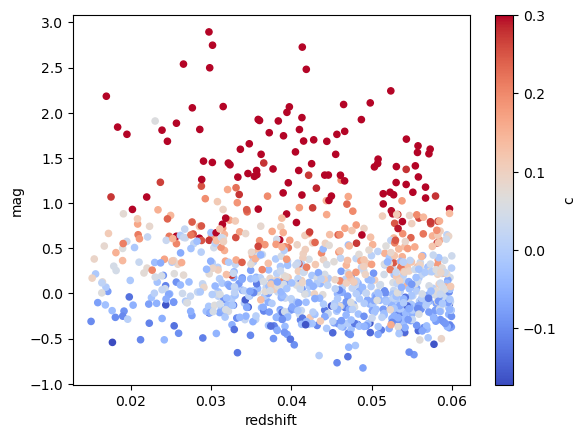

In [5]:
data.plot.scatter("redshift", "mag", c="c", vmax=0.3, cmap="coolwarm")

In [6]:
from standax import standardisation

In [10]:
data_to_fit = data[["mag", "mag_err", "x1", "x1_err", "c", "c_err", "h_low", "h_low_err",
                    "cov_mag_c", "cov_mag_x1", "cov_x1_c"]].dropna()

(best_params_l, sigmaint_l, mcmc_l), this_l = standardisation.standardise_snia(data_to_fit,
                                                      init=[-0.2, 3.2, 0.15], 
                                                      xkeys=["x1", "c", "h_low"], 
                                                      sigmaint_guess=0.15, 
                                                      model="linear", 
                                                      nfetch=5, verbose=False,
                                                     )

In [8]:
import jax.numpy as jnp
from jax import tree_util
print(tree_util.tree_map(lambda x: jnp.mean(x, axis=0), mcmc_l.get_samples()))
print(tree_util.tree_map(lambda x: jnp.std(x, axis=0), mcmc_l.get_samples()))

{'coefs': Array([-0.15680662,  3.1202345 ,  0.14251088], dtype=float32), 'offset': Array(-0.06603711, dtype=float32)}
{'coefs': Array([0.01029437, 0.04984552, 0.02393577], dtype=float32), 'offset': Array(0.01634949, dtype=float32)}
